# Installing EasyVVUQ

Before we do anything else we need to install EasyVVUQ for use in this notebook. We also want to clone the git repository because it contains some files used in this tutorial.

In [94]:
!pip install easyvvuq
!git clone https://github.com/UCL-CCS/EasyVVUQ

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
fatal: destination path 'EasyVVUQ' already exists and is not an empty directory.


$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$
# A Cooling Coffee Cup with Polynomial Chaos Expansion

In this tutorial we will perform a Polynomial Chaos Expansion for a
model of a cooling coffee cup. The model uses Newton's law of cooling to
evolve the temperature, $T$, over time ($t$) in an environment at
$T_{env}$ :

$$\frac{dT(t)}{dt} = -\kappa (T(t) -T_{env})$$

The constant $\kappa$ characterizes the rate at which the coffee cup
transfers heat to the environment. In this example we will analyze this
model using the polynomial chaos expansion (PCE) UQ algorithm. We will
use a constant initial temperature $T_0 = 95 ^\circ\text{C}$, and vary
$\kappa$ and $T_{env}$ using a uniform distribution in the ranges
$0.025-0.075$ and $15-25$ respectively.

The model was implemented as a Python script. But your code does not have to be written in Python and is indeed not expected to be. 

## EasyVVUQ Script Overview

We illustrate the intended workflow using the following basic example
script, a python implementation of the cooling coffee cup model used in
the textit{uncertainpy} documentation (code for which is in the
tests/cooling/ subdirectory of the EasyVVUQ distribution directory). The
code takes a small key/value pair input and outputs a comma separated
value CSV) file.

The input files for this tutorial are the *cooling\_model* application
(`cooling_model.py <tutorial_files/cooling_model.py>`), an input
template (`cooling.template <tutorial_files/cooling.template>`) and the
EasyVVUQ workflow script
(`easyvvuq_pce_tutorial.py <tutorial_files/easyvvuq_pce_tutorial.py>`).

## Set-up

For this example we import both easyvvuq and chaospy (for the
distributions). EasyVVUQ will be referred to as 'uq' in the code. :

In [95]:
import easyvvuq as uq
import chaospy as cp

## Create a new Campaign

We start by creating an
EasyVVUQ Campaign. Here we call it 'coffee\_pce'. :

In [96]:
my_campaign = uq.Campaign(name='coffee_pce')
print(my_campaign)

db_location = sqlite:////home/jovyan/tutorials/VECMAtk/EasyVVUQ/Cooling_Cup/coffee_pce18595a0n/campaign.db
active_sampler_id = None
campaign_name = coffee_pce
campaign_dir = /home/jovyan/tutorials/VECMAtk/EasyVVUQ/Cooling_Cup/coffee_pce18595a0n
campaign_id = 1
log = []



## Parameter space definition

The parameter space is defined using a dictionary. Each entry in the
dictionary follows the format:

`"parameter_name": {"type" : "<value>", "min": <value>, "max": <value>, "default": <value>}`

With a defined type, minimum and maximum value and default. If the
parameter is not selected to vary in the Sampler (see below) then the
default value is used for every run. In this example, our full parameter
space looks like the following: :

In [98]:
params = {
    "temp_init": {"type": "float", "min": 0.0, "max": 100.0, "default": 95.0},
    "kappa": {"type": "float", "min": 0.0, "max": 0.1, "default": 0.025},
    "t_env": {"type": "float", "min": 0.0, "max": 40.0, "default": 15.0},
    "out_file": {"type": "string", "default": "output.csv"}
}

## App Creation

In this example the GenericEncoder and SimpleCSV, both included in the
core EasyVVUQ library, were used as the encoder/decoder pair for this
application. :

In [99]:
import os
from pathlib import Path

encoder = uq.encoders.GenericEncoder(
    template_fname='EasyVVUQ/tests/cooling/cooling.template',
    delimiter='$',
    target_filename='cooling_in.json')

decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                            output_columns=["te"],
                            header=0)

In this workflow all application runs will be analyzed as individual
datapoint, so we set the collator to AggregateSamples without averaging.
This element simply extracts information using the assigned decoder and
adds it to a summary dataframe. :

In [100]:
collater = uq.collate.AggregateSamples(average=False)

GenericEncoder performs simple text substitution into a supplied
template, using a specified delimiter to identify where parameters
should be placed. The template is shown below (\$ is used as the
delimiter). The template substitution approach is likely to suit most
simple applications but in practice many large applications have more
complex requirements, for example the multiple input files or the
creation of a directory hierarchy. In such cases, users may write their
own encoders by extending the BaseEncoder class. :

In [ ]:
{
   "T0":"$temp_init",
   "kappa":"$kappa",
   "t_env":"$t_env",
   "out_file":"$out_file"
}

As can be inferred from its name SimpleCSV reads CVS files produced by
the cooling model code. Again many applications output results in
different formats, potentially requiring bespoke Decoders. Having
created an encoder, decoder and parameter space definition for our
$cooling$ app, we can add it to our campaign. :

In [101]:
# Add the app (automatically set as current app)
my_campaign.add_app(name="cooling",
                    params=params,
                    encoder=encoder,
                    decoder=decoder,
                    collater=collater)

## The Sampler

The user specified which parameters will vary and their corresponding
distributions. In this case the kappa and t\_env parameters are varied,
both according to a uniform distribution: :

In [102]:
vary = {
    "kappa": cp.Uniform(0.025, 0.075),
    "t_env": cp.Uniform(15, 25)
}

To perform a polynomial chaos expansion we will create a PCESampler,
informing it which parameters to vary, and what polynomial rder to use
for the PCE. :

In [103]:
my_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=3)

Finally we set the campaign to use this sampler. :

In [104]:
my_campaign.set_sampler(my_sampler)

Calling the campaign's draw\_samples() method will cause the specified
number of samples to be added as runs to the campaign database, awaiting
encoding and execution. If no arguments are passed to draw\_samples()
then all samples will be drawn, unless the sampler is not finite. In
this case PCESampler is finite (produces a finite number of samples) and
we elect to draw all of them at once: :

In [105]:
my_campaign.draw_samples()

## Execute Runs

my\_campaign.populate\_runs\_dir() will create a directory hierarchy
containing the encoded input files for every run that has not yet been
completed. 

In [107]:
my_campaign.populate_runs_dir()

Finally, in this example, a shell command is executed in each
directory to execute the simple test code. In practice (in a real HPC
workflow) this stage would be best handled using, for example, a pilot
job manager. :

In [108]:
import os
my_campaign.apply_for_each_run_dir(uq.actions.ExecuteLocal("{} cooling_in.json".format(os.path.abspath('EasyVVUQ/tests/cooling/cooling_model.py')), interpret="python3"))

## Collation and analysis

Calling my\_campaign.collate() at any stage causes the campaign to
aggregate decoded simulation output for all runs which have not yet been
collated. :

In [109]:
my_campaign.collate()

This collated data is stored in the campaign database. An analysis
element, here PCEAnalysis, can then be applied to the campaign's
collation result. :

In [110]:
my_analysis = uq.analysis.PCEAnalysis(sampler=my_sampler, qoi_cols=["te"])
my_campaign.apply_analysis(my_analysis)

The output of the analysis can be next queried in order to get detailed statistics:

In [111]:
# Get Descriptive Statistics
results = my_campaign.get_last_analysis()

mean = results.describe()['te']['mean']
std = results.describe()['te']['std']
p10 = results.describe()['te']['10%']
p90 = results.describe()['te']['90%']
print(f'Mean:\n{mean}')
print(f'Std:\n{std}')
print(f'p10:\n{p10}')
print(f'p90:\n{p10}')

Mean:
[95.         90.14480222 85.62853232 81.42607272 77.51425404 73.87169698
 70.47867197 67.31696485 64.36975852 61.62152061 59.05790055 56.66563881
 54.43247737 52.34708481 50.39898016 48.57846789 46.87657596 45.28499994
 43.79605167 42.40261031 41.09807879 39.87634425 38.7317402  37.65901235
 36.65328742 35.71004408 34.82508628 33.99451843 33.21472289 32.48233907
 31.79424428 31.14753593 30.53951502 29.96767121 29.42966884 28.92333398
 28.44664273 27.99771014 27.57478008 27.17621601 26.80049218 26.44618579
 26.11196953 25.79660476 25.49893528 25.21788137 24.95243443 24.70165205
 24.46465327 24.24061436 24.0287648  23.82838365 23.63879613 23.45937039
 23.28951465 23.12867447 22.97633017 22.83199453 22.69521062 22.56554974
 22.44260959 22.32601246 22.21540368 22.11045006 22.0108385  21.91627469
 21.82648191 21.74119985 21.6601836  21.58320266 21.51004002 21.4404913
 21.37436398 21.31147665 21.25165828 21.19474764 21.14059263 21.08904979
 21.0399837  20.99326654 20.94877763 20.906402

## I want to see how the results might look:





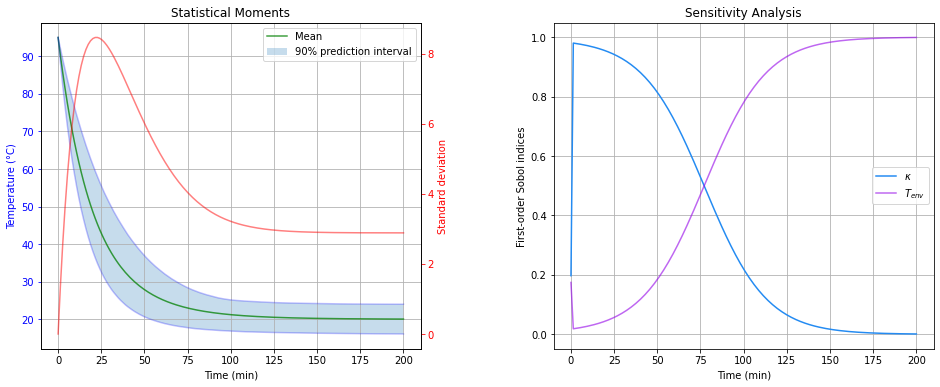

In [112]:
import matplotlib.pyplot as plt
import numpy as np

mean = results.describe()['te']['mean']
std = results.describe()['te']['std']
p10 = results.describe()['te']['10%']
p90 = results.describe()['te']['90%']

s1_kappa = results._get_sobols_first('te', 'kappa')
s1_t_env = results._get_sobols_first('te', 't_env')

t = np.linspace(0, 200, 150)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax1.plot(t, mean, 'g-', alpha=0.75, label='Mean')
ax1.plot(t,  p10, 'b-', alpha=0.25)
ax1.plot(t,  p90, 'b-', alpha=0.25)
ax1.fill_between(
  t,
  p10,
  p90,
  alpha=0.25,
  label='90% prediction interval')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Temperature (°C)', color='b')
ax1.tick_params('y', colors='b')
ax1.legend()

ax1t = ax1.twinx()
ax1t.plot(t, std, 'r-', alpha=0.5)
ax1t.set_ylabel('Standard deviation', color='r')
ax1t.tick_params('y', colors='r')

ax1.grid()
ax1.set_title('Statistical Moments')

ax2.plot(t, s1_kappa, '-', color ='#248BF2', label=r'$\kappa$')
ax2.plot(t, s1_t_env, '-', color ='#9402E8', alpha=0.6,label=r'$T_{env}$')

ax2.set_xlabel('Time (min)')
ax2.set_ylabel('First-order Sobol indices')
ax2.set_title('Sensitivity Analysis')
ax2.grid()
ax2.legend()

plt.subplots_adjust(wspace=0.35)

plt.show()

These plots show the statistical moments (mean, variance, and 90% prediction interval) and the sensitivity analysis of the model to each parameter, expressed through the first-order Sobol indices.

## I don't want to use Polynomial Chaos

If you wish to use something other than PCE, it is simply a matter of
changing the sampling and analysis element used. For example, to use a
Stochastic Collocation approach, replace the sampler line with: :

In [ ]:
my_sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=3)

And the analysis can be done with: :

In [ ]:
my_analysis = uq.analysis.SCAnalysis(sampler=my_sampler, qoi_cols=["te"])
my_campaign.apply_analysis(my_analysis)